# <font color='blue'>Decomposição em Valores Singulares<br><br> (Singular Value Decomposition  - SVD)</font>

## Aplicações

### Material produzido por Luis Gustavo Nonato

ICMC-USP

----

## Conteúdo
- Aplicações de SVD
  - Compressão de Informação
  - Semântica latente de coleção de documentos
  - Sistemas de recomendação
---

# <font color='blue'>SVD e Compressão de Informação</font>
A propriedade de aproximação de posto reduzido da decomposição SVD fornece um mecanismo de compressão de informação que pode ser utilizado em diversos cenários, incluindo compressão de imagens.

Considere a imagem <font font-family='Verdana'> florbw.jpeg</font> disponível no repositório. Vamos comprimir a imagem utilizando SVD.

In [1]:
from PIL import Image  # pacote python para tratamento de imagens
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

(225, 225)


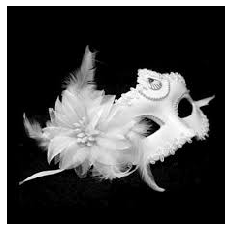

In [2]:
# carregando a imagem e convertendo para tons de cinza + alpha
im = Image.open("florbw.jpeg").convert('LA')

# transformando a imagem em uma matriz
X = np.asarray(im)[:,:,0]
print(X.shape)

plt.axis('off')
plt.imshow(X,cmap='gray')

In [5]:
print(X[100:110,100:110])

[[197 202 210 220 224 220 230 224 217 131]
 [219 219 223 230 226 227 225 255 221 181]
 [232 228 229 236 232 233 229 251 213 197]
 [237 230 230 238 230 230 243 221 204 200]
 [229 228 232 236 223 238 237 214 196 200]
 [228 230 233 233 229 240 227 203 201 212]
 [227 232 233 229 236 239 213 193 210 225]
 [227 233 233 225 241 231 203 195 218 226]
 [227 231 230 224 239 220 200 208 224 220]
 [228 227 226 226 233 209 204 220 226 221]]


In [7]:
# calculando SVD
U,S,Vt = np.linalg.svd(X)

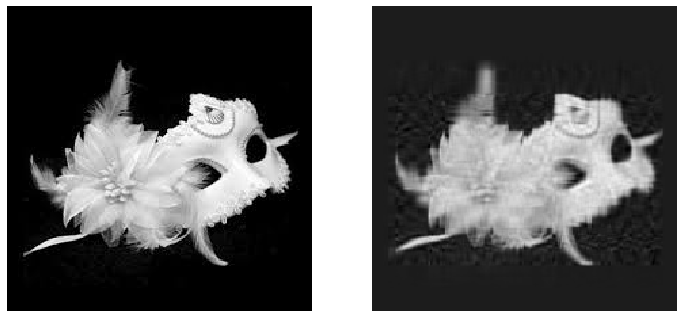

In [13]:
k = 20
# Sk = np.diag(S[0:k])
# SkVt = np.dot(Sk,Vt[0:k,:])
# Xk = np.dot(U[:,0:k],SkVt)

Xk = np.linalg.multi_dot([U[:,0:k],np.diag(S[0:k]),Vt[0:k,:]])

plt.rcParams['figure.figsize'] = [12, 6]
f,(ax1,ax2) = plt.subplots(1,2)
ax1.axis('off')
ax1.imshow(X,cmap='gray')
ax2.axis('off')
ax2.imshow(Xk,cmap='gray')

In [12]:
# Calculando a porcentagem de compressão

#bits_original = X.shape[0]*X.shape[1]*16
bits_original = X.itemsize*X.shape[0]*X.shape[1]
print('Numero de bites original: ',bits_original)

bits_comprimido = X.itemsize*k*(X.shape[0]+X.shape[1])
print('Numero de bites comprimido: ',bits_comprimido)

print('Porcentagem de compressão: ', 100-bits_comprimido*100/bits_original)

Numero de bites original:  50625
Numero de bites comprimido:  9000
Porcentagem de compressão:  82.22222222222223


# <font color='blue'>Semântica Latente de Coleção de Documentos - (Latent Semantic Index - LSI)</font>

Suponha que a matriz $\mathbf{A}$ corresponda a uma matriz _Documentos $\times$ Palavras_. 

**Referência**: [Alex Thomo, Latent Semantic Analysis](https://www.engr.uvic.ca/~seng474/svd.pdf)

Vamos interpretar a matrix _Palavras $\times$ Documentos_ de modo que os documentos estejam nas colunas e as palavras nas linhas da matriz, ou seja:

$$
\underbrace{\left.\begin{array}{c}
\begin{bmatrix}
 & & & \\
  & & & \\
   & & & \\
    & & & 
\end{bmatrix}
\end{array}\right\}}_{documentos}\mbox{palavras}
$$

## Extração de Tópicos (Latent Semantic Index - LSI)
A ideia de extração de tópicos via SVD é utilizar SVD compacto (apenas $k$ autovetores e autovalores serão calculados - $\mathbf{U}_k\mathbf{\Sigma}_k\mathbf{V}_k$) para identificar quais palavras são mais representativas para cada documento.

O fato importante é que as colunas de $\mathbf{\Sigma}_k\mathbf{V}_k^\top$ (linhas de $\mathbf{V}_k$) são os coeficientes utilizados para aproximar as colunas da matriz _Palavras $\times$ Documentos_ como combinação linear das colunas de $\mathbf{U}_k$. Desta forma, as colunas de $\mathbf{\Sigma}_k\mathbf{V}_k^\top$ fornecem as “coordenadas” de cada documento na base $\mathbf{U}_k$. Intuitivamente, documentos semelhantes devem possuir coordenadas semelhantes o que permite uma análise semântica dos documentos. Ou seja, as colunas de $\mathbf{\Sigma}_k\mathbf{V}_k^\top$ permitem encontrar documentos semelhantes.

Outra observação importante é que as linhas de $\mathbf{U}_k$ contém a informação/relação entre termos, ou seja, as linhas de $\mathbf{U}_k$ refletem a “importância” das palavras em um determinado "tópico", os quais caracterizam os grupos de documentos. Assim, as colunas de $\mathbf{U}_k$ é o espaço de tópicos.

Considere a relação:

$$
\mathbf{A}^\top \approx \mathbf{V}_k\mathbf{\Sigma}_k\mathbf{U}_k^\top
\Longrightarrow \mathbf{V}_k \approx \mathbf{A}^\top\mathbf{U}_k\mathbf{\Sigma}_k^{-1}
$$

$\mathbf{A}^\top\mathbf{U}_k$ é a projeção de documentos no espaço de "tópicos". Se considerarmos um único documento $\mathbf{a}$, temos que 

$$
\hat{\mathbf{a}}=\mathbf{a}^\top\mathbf{U}_k\mathbf{\Sigma}_k^{-1}
$$

Comparando $\hat{\mathbf{a}}$ com as linhas de $\mathbf{V}_k$ podemos recuperar os documentos mais similares à $\mathbf{a}$.

## Semântica Latente com Python

Para exemplificar o uso de LSI utilizaremos a base de dados disponível no arquivo <font font-family='Verdana'> bag_of_words.csv </font>.

In [16]:
import pandas as pd
import numpy as np

# a BoW bag_of_words_c2.csv foi extraida de uma colecao de documentos
# contendo mensagens sobre dois assuntos 'hockey' e 'vendas'
bow = pd.read_csv('../Datasets/bag_of_words_c2.csv')
bow.set_index('Unnamed: 0',inplace=True)

In [17]:
# transladando o corpus original para fique no forma Palavras X Documentos

bow = bow.T
print(bow.head())

Unnamed: 0  ho62  ho4  ho65  ho3  ho53  ho54  sa21  sa2  sa19  ho38  ...  \
pete           0    0     0    0     0     0     0    0     0     0  ...   
broken         0    0     0    0     0     0     0    0     0     0  ...   
har            0    0     0    0     0     0     0    0     0     5  ...   
routin         0    0     0    0     0     0     0    0     0     0  ...   
beer           0    0     0    0     0     0     0    0     0     0  ...   

Unnamed: 0  ho29  ho11  ho43  ho44  ho10  ho17  ho28  ho21  ho26  ho19  
pete           0     0     0     0     0     0     0     0     0     0  
broken         0     0     0     0     0     0     0     0     0     0  
har            0     0     0     0     0     0     0     0     0     0  
routin         0     0     0     0     0     0     0     0     0     0  
beer           0     0     0     0     0     0     0     0     0     0  

[5 rows x 88 columns]


In [18]:
# Aplicando o SVD truncado para realizar a análise semântica latente
from sklearn.decomposition import TruncatedSVD

A = bow.values
r = 5

tsvd = TruncatedSVD(n_components=r) 
U = tsvd.fit_transform(A)
Sigma = tsvd.explained_variance_ratio_
Vt = tsvd.components_

In [19]:
print(A.shape)
print(U.shape)
print(Vt.shape)

(4704, 88)
(4704, 5)
(5, 88)


$$
\begin{bmatrix}
 & | & \\
\cdots & A_i & \cdots \\
  & | & 
\end{bmatrix}\approx
\begin{bmatrix}
| & | & \\
U_1 & U_2 & \cdots \\
|  & | & 
\end{bmatrix}\Sigma_k
\begin{bmatrix}
 & | & \\
\cdots & V^\top_i & \cdots \\
  & | & 
\end{bmatrix}=
\sqrt{\lambda_1}V^\top_{1i}
\begin{bmatrix}
| \\
 U_1 \\
 |  
\end{bmatrix}+
\sqrt{\lambda_2}V^\top_{2i}
\begin{bmatrix}
| \\
 U_2 \\
 |  
\end{bmatrix}+\cdots
$$

In [21]:
# clusterizando colunas de Vt para encontrar documentos semelhantes 
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

kmeans = KMeans(n_clusters=15, random_state=1).fit(Vt.T)
sim_docs_km = kmeans.labels_
#print(sim_docs_km)

# agg = AgglomerativeClustering(linkage='single', n_clusters=5).fit(Vt.T)
# sim_docs_agg = agg.labels_

docs = bow.columns.values
for i in np.unique(sim_docs_km):
    docs_ids = np.argwhere(sim_docs_km == i)
    print(i,'-->',docs[docs_ids])

0 --> [['ho62']
 ['ho4']
 ['ho54']
 ['ho30']
 ['ho12']
 ['ho41']
 ['ho48']
 ['ho14']
 ['ho35']
 ['ho60']
 ['ho45']
 ['ho42']
 ['ho19']]
1 --> [['ho46']
 ['ho16']
 ['ho10']]
2 --> [['sa3']
 ['sa13']]
3 --> [['ho15']
 ['ho50']
 ['ho6']]
4 --> [['sa2']
 ['sa5']
 ['sa17']
 ['sa6']
 ['sa14']
 ['sa9']
 ['sa24']]
5 --> [['sa19']
 ['sa8']
 ['sa12']
 ['sa7']]
6 --> [['ho65']
 ['ho3']
 ['ho38']
 ['ho55']
 ['ho39']
 ['ho56']
 ['ho29']]
7 --> [['ho31']
 ['ho36']
 ['ho64']
 ['ho24']
 ['ho58']]
8 --> [['ho33']]
9 --> [['sa21']
 ['sa10']
 ['ho63']
 ['sa11']
 ['sa18']
 ['sa4']
 ['sa20']
 ['sa22']
 ['sa1']
 ['ho7']
 ['ho57']
 ['sa15']
 ['sa23']]
10 --> [['ho13']
 ['ho25']
 ['ho9']
 ['ho1']
 ['ho27']]
11 --> [['ho49']
 ['ho32']
 ['ho59']
 ['ho51']
 ['ho43']]
12 --> [['ho52']
 ['ho17']]
13 --> [['ho2']
 ['ho37']]
14 --> [['ho53']
 ['ho5']
 ['sa16']
 ['ho23']
 ['ho22']
 ['ho47']
 ['ho40']
 ['ho34']
 ['ho8']
 ['ho18']
 ['ho20']
 ['ho11']
 ['ho44']
 ['ho28']
 ['ho21']
 ['ho26']]


In [14]:
# Entendendo os topicos clusterizando as colunas de U
from sklearn.cluster import KMeans

kmeans_U = KMeans(n_clusters=2, random_state=1).fit(U.T)
topics = kmeans_U.labels_

words = bow.index.values

for i in np.unique(topics):
    cid = np.argwhere(topics == i).flatten()
    print(i,cid)
    T = np.argsort(np.sum(U[:,cid], axis=1))
    print(words[T[-10:]])

0 [1 2 3 4]
['period' 'annual' 'wolverin' 'mpc' 'hulk' 'new' 'comic' 'vs' 'copi' 'do']
1 [0]
['score' 'pp' 'season' 'blue' 'shot' 'goal' 'team' 'period' 'game' 'play']


## <font color='blue'> Sistema de Recomendação </font>

**Referência**: 
- [Matrix Factorization for Recomendation Systems](https://www.asc.ohio-state.edu/statistics/dmsl/Koren_2009.pdf)
- [SINGULAR VALUE DECOMPOSITION INRECOMMENDER SYSTEMS](https://repository.tcu.edu/bitstream/handle/116099117/11320/Nguyen__Anh-Honors_Project.pdf?sequence=1)

O problema de recomendação consiste em encontrar o produto mais provável de compra por um consumidor. Em geral, tais sistemas tomam como base uma matriz onde as linhas são os consumidores e as colunas são as avaliações feitas pelos consumidores para cada produto, chamada de matriz **consumidor-produto**. Por exemplo:

$$
\begin{matrix}
             & prod 1 & prod 2 & prod 3 & prod 4 & prod 5 & prod 6 & prod 7\\\hline
\mbox{Joao} &  & 1 &  &  & 5 &  & 4\\
\mbox{Mari} &  &  &  & 2 & 4 &  & \\
\mbox{Jose} &  & 5 &  & 1 &  & 1 & 3\\
\mbox{Carl} & 2 & 5 &  &  &  & 4 & 3\\
\mbox{Nabi}  &   &   &  & 3 & 5 & 1 &  \\
\mbox{Luci}  &  3 & 4  &  & 3 &   &   & 1\\
\end{matrix}
$$

O processo de recomendação consiste em 3 etapas:
1. preencher os dados faltantes na matriz consumidor-produto
2. calcular a decomposição SVD da matriz preenchida
3. considerar uma aproximação de posto $k$ na decomposição SVD
4. calcular o coeficiente $c_p$ que indica qual a importancia dos produtos para cada consumidor.

**Preenchimento da matriz**<br>
Existem muitas estratégias diferentes para o preenchimento de dados faltantes, como por exemplo preenchimento com zeros ou com a média das avaliações de cada produto. 

**Coeficiente $c_p$** <br>
Dada a matriz $\mathbf{U}_k$ ($k$-colunas), $\Sigma_k$ e $\mathbf{V}_k$ obitidas do
SVD com aproximação de posto $k$, o coeficiente $r(i,j)$ do comsumidor $i$ com relação ao produto $j$ é calculado como:

$$
\mathbf{C} = \mathbf{U}_k\Sigma_k^{1/2}\\
\mathbf{P} = \Sigma_k^{1/2}\mathbf{V}^{\top}_k\\ \\
r(i,j) = <C[i],P[:,j]>
$$

quanto maior o valor de $r(i,j)$, mais importante é o produto $j$ para o consumidor $i$.

O raciocínio do método acima é que as **linhas** de $\mathbf{C}$ geram uma representação latente (representação abstrata) onde os consumidores são mapeados. Da mesma forma, as colunas de $\mathbf{P}$ são uma representação latente para os produtos. 

O coeficiente $r(i,j)$ mede o quão correlacionado estão o consumidor $i$ com o produto $j$. Se um consumidor $i$ tem alta correlação com o produto $j$ mas nunca adquiriu tal produto, $j$ é recomendado para o consumidor $i$.

In [22]:
CxP = np.array([[0, 1, 0, 0, 5, 0, 4],
                [0, 0, 0, 2, 4, 0, 0],
                [0, 5, 0, 1, 0, 1, 3],
                [2, 5, 0, 0, 0, 4, 3],
                [0, 0, 0, 3, 5, 1, 0],
                [3, 4, 0, 3, 0, 0, 1]]).astype(float)

consumidores = ['Joao','Mari','Jose','Carl','Nabi','Luci']

# meanc = np.mean(CxPo,axis=0)
# zeros = np.where(CxPo==0)
# CxP = CxP.copy()
# CxP[zeros] = np.take(meanc, zeros[1])

In [25]:
U,S,Vt = np.linalg.svd(CxP)

# calculando as representacoes latentes de consumidores C e produtos P 
k = 3
C = np.dot(U[:,:k],np.diag(np.sqrt(S[:k])))
P = np.dot(np.diag(np.sqrt(S[:k])),Vt[:k,:])

# encontrado o produto mais provável para um cosumidor C[i]
i = int(np.random.randint(0,CxP.shape[0],1))
#i=4
rij = np.dot(C[i,:],P).ravel()   # relevancia dos produtos para o consumidor i

sij = np.argsort(rij)[::-1]
print('produtos mais importantes para o consumidor',i,'\n',sij)
print('avaliacao dos pelo consumidor',i,'\n',CxP[i])

produtos mais importantes para o consumidor 3 
 [1 6 5 0 3 2 4]
avaliacao dos pelo consumidor 3 
 [2. 5. 0. 0. 0. 4. 3.]


In [28]:
# validando o examplo: vamos encontrar o 2 consumidores mais pareceidos com i
cij = np.dot(C[i,:]/np.linalg.norm(C[i,:]),C.T/np.linalg.norm(C.T,axis=0))
cmm = np.argsort(cij)[::-1].ravel()

# print(cmm)
# print(np.dot(C[i,:]/np.linalg.norm(C[i,:]),C.T[:,1]/np.linalg.norm(C.T[:,1],axis=0)))
# print(CxPo[1])
print('produtos recomendados ao',consumidores[i],sij,'\n')

print(4*' ',np.arange(7))
print(10*'--')
print(consumidores[i],
      CxP[i].ravel().astype(int)) # consumidor escolhido

for j in cmm:
    if j != i:           
        print(consumidores[j],CxP[j].astype(int))


produtos recomendados ao Carl [1 6 5 0 3 2 4] 

     [0 1 2 3 4 5 6]
--------------------
Carl [2 5 0 0 0 4 3]
Jose [0 5 0 1 0 1 3]
Luci [3 4 0 3 0 0 1]
Joao [0 1 0 0 5 0 4]
Nabi [0 0 0 3 5 1 0]
Mari [0 0 0 2 4 0 0]
